In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow_datasets as tfds
from ssd_loss import CustomLoss
from utils import bouding_box_util
import getData
# from ssd300 import ssd_300
import augmentation
import bbox
import train_feed
from datetime import datetime

In [2]:
batch_size = 10

In [3]:
# train_data, info = getData.get_dataset("voc/2012", "train")
# valid_data, info_val = getData.get_dataset("voc/2012", "validation")
# test_data, info_test = getData.get_dataset("voc/2012", "test")

In [4]:
# train_total_items = getData.get_total_item_size(info, "train")
# val_total_items = getData.get_total_item_size(info_val, "validation")
# test_total_items = getData.get_total_item_size(info_test, "test")

train_data, info = getData.get_dataset("voc/2012", "train+validation")
val_data, _ = getData.get_dataset("voc/2012", "test")
train_total_items = getData.get_total_item_size(info, "train+validation")
val_total_items = getData.get_total_item_size(info, "test")

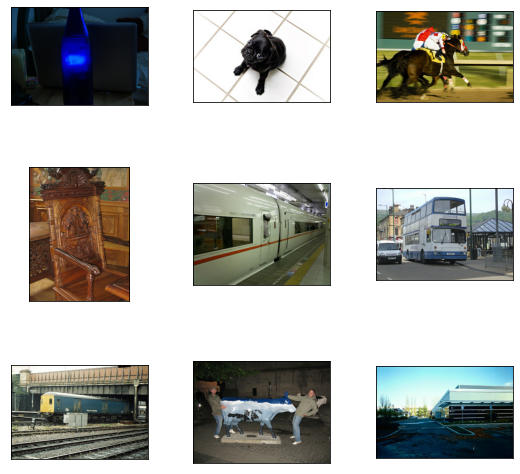

In [5]:
fig = tfds.show_examples(train_data,info)

In [6]:
labels = getData.get_labels(info)
labels = ["bg"] + labels
n_classes = len(labels)
img_size = 300
labels, n_classes

(['bg',
  'aeroplane',
  'bicycle',
  'bird',
  'boat',
  'bottle',
  'bus',
  'car',
  'cat',
  'chair',
  'cow',
  'diningtable',
  'dog',
  'horse',
  'motorbike',
  'person',
  'pottedplant',
  'sheep',
  'sofa',
  'train',
  'tvmonitor'],
 21)

In [7]:
#preprocessing img
# train_data = train_data.map(lambda x : getData.preprocessing(x, img_size, img_size, augmentation.apply))
# valid_data = valid_data.map(lambda x : getData.preprocessing(x, img_size, img_size))
# test_data = test_data.map(lambda x : getData.preprocessing(x, img_size, img_size))
train_data = train_data.map(lambda x : getData.preprocessing(x, img_size, img_size, augmentation.apply))
val_data = val_data.map(lambda x : getData.preprocessing(x, img_size, img_size))

In [8]:
#shape data
data_shapes = getData.get_data_shapes()
padding_values = getData.get_padding_values()
train_data = train_data.shuffle(batch_size*4).padded_batch(batch_size, padded_shapes=data_shapes, padding_values=padding_values)
# test_data = test_data.padded_batch(batch_size, padded_shapes=data_shapes, padding_values=padding_values)
val_data = val_data.padded_batch(batch_size, padded_shapes=data_shapes, padding_values=padding_values)

In [9]:
# #model
# ssd_model = ssd_300()
# ssd_custom_losses = CustomLoss()
# ssd_model.compile(optimizer=Adam(learning_rate=1e-3),
#                   loss=[ssd_custom_losses.loc_loss_fn, ssd_custom_losses.conf_loss_fn])
# #Initializing model with dummy data for load weights with optimizer state and also graph construction.
# ssd_model((tf.random.uniform((1, 300, 300, 3))))

In [10]:
#model
from utils.ssd_vgg16 import init_model, get_model
hyper_params = train_feed.get_hyper_params("vgg16")
hyper_params["total_labels"] = len(labels)
ssd_model,total_labels = get_model(hyper_params)
ssd_custom_losses = CustomLoss(hyper_params["neg_pos_ratio"], hyper_params["loc_loss_alpha"])
ssd_model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss=[ssd_custom_losses.loc_loss_fn, ssd_custom_losses.conf_loss_fn])
init_model(ssd_model)

print(total_labels, len(labels))

TypeError: unsupported operand type(s) for %: 'ListWrapper' and 'int'

In [ ]:
# We calculate prior boxes for one time and use it for all operations because of the all images are the same sizes
feature_map_shapes= [19, 10, 5, 3, 2, 1]
aspect_ratios= [[1., 2., 1./2.],
                [1., 2., 1./2., 3., 1./3.],
                [1., 2., 1./2., 3., 1./3.],
                [1., 2., 1./2., 3., 1./3.],
                [1., 2., 1./2.],
                [1., 2., 1./2.]]
hyper_params = train_feed.get_hyper_params("vgg16")
hyper_params["total_labels"] = len(labels)

prior_boxes = bbox.generate_prior_boxes(feature_map_shapes, aspect_ratios)
ssd_train_feed = train_feed.generator(train_data, prior_boxes)
ssd_val_feed = train_feed.generator(val_data, prior_boxes)

In [ ]:
#training call backs
save_path="./saved_model/ssd300_vgg16.h5"
log_path = "logs/{}{}/{}".format("vgg16", "", datetime.now().strftime("%Y%m%d-%H%M%S"))
checkpoint_callback = ModelCheckpoint(save_path, monitor="val_loss", save_best_only=True, save_weights_only=True)
tensorboard_callback = TensorBoard(log_dir=log_path)
learning_rate_callback = LearningRateScheduler(train_feed.scheduler, verbose=0)

In [ ]:
epochs=3
step_size_train = train_feed.get_step_size(train_total_items, batch_size)
step_size_val = train_feed.get_step_size(val_total_items, batch_size)
ssd_model.fit(ssd_train_feed,
              steps_per_epoch=step_size_train,
              validation_data=ssd_val_feed,
              validation_steps=step_size_val,
              epochs=epochs,
              callbacks=[checkpoint_callback, tensorboard_callback, learning_rate_callback])

Epoch 1/3


InvalidArgumentError:  required broadcastable shapes at loc(unknown)
	 [[node binary_crossentropy/logistic_loss/mul (defined at <ipython-input-27-28227aec1e4f>:4) ]] [Op:__inference_train_function_14316]

Errors may have originated from an input operation.
Input Source operations connected to node binary_crossentropy/logistic_loss/mul:
 model_1/labels_head/concat (defined at c:\Users\thai\Desktop\ssd\thai\cnn_localization\ssd\utils\bouding_box_wrapper.py:41)

Function call stack:
train_function
